In [1]:
import json

import pickle  
import spacy
import json
import numpy as np
# import pandas as pd
# from pandas import Series
import logging
import numpy
import nltk
from nltk.corpus import wordnet as wn
import os

import csv
from tqdm import tqdm_notebook as tqdm

nlp = spacy.load("en_core_web_sm")

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
sw = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')

['Eighty', 'seven', 'miles', 'to', 'go', 'yet', 'Onward']

In [3]:
def load_dataset(filename):
    # read a winogrande style jsonl file
    # qID, sentence, option1, option2, answer
    this_set = []
    
    
    with open(filename,"r") as json_file:
        json_list = list(json_file)

        for json_str in json_list:
            result = json.loads(json_str)
            this_set.append(result)
    print("Loaded "+ filename + " with "+ str(len(this_set)) + " items.")
    return this_set

In [4]:
wsc = load_dataset("wsc.jsonl")
xs = load_dataset("train_xs.jsonl")
s = load_dataset("train_s.jsonl")
m = load_dataset("train_m.jsonl")
l = load_dataset("train_l.jsonl")
xl = load_dataset("train_xl.jsonl")

# s_l = load_dataset("selected_l.jsonl")

# s1 = load_dataset("split_xl_1.jsonl")
# s2 = load_dataset("split_xl_2.jsonl")
# s3 = load_dataset("split_xl_3.jsonl")
print(wsc[0])

Loaded wsc.jsonl with 279 items.
Loaded train_xs.jsonl with 160 items.
Loaded train_s.jsonl with 640 items.
Loaded train_m.jsonl with 2558 items.
Loaded train_l.jsonl with 10234 items.
Loaded train_xl.jsonl with 40398 items.
{'qID': 'wsc0', 'sentence': 'The city councilmen refused the demonstrators a permit because _ feared violence.', 'option1': 'The city councilmen', 'option2': 'The demonstrators', 'answer': '1'}


In [6]:
print(wsc[1])

{'qID': 'wsc1', 'sentence': 'The city councilmen refused the demonstrators a permit because _ advocated violence.', 'option1': 'The city councilmen', 'option2': 'The demonstrators', 'answer': '2'}


In [23]:
def convert_grande_to_bert_commonsense(dataset, name):
    with open(name+".txt", "w", encoding="utf-8") as f:
        for i,piece in enumerate(dataset):
            text = piece["sentence"].replace("_", "[MASK]")
            pron = "[MASK]"
            op1 = piece["option1"]
            op2 = piece["option2"]
            if piece["answer"] == "1":
                answer = op1
            elif piece["answer"] == "2":
                answer = op2
            else:
                print(piece)
                print("ALERT!")
                
            f.write(text)
            f.write("\n")
            f.write(pron)
            f.write("\n")
            f.write(op1)
            f.write(",")
            f.write(op2)
            f.write("\n")
            f.write(answer)
            
            if i != (len(dataset)-1):
                f.write("\n")
                f.write("\n")
                
def convert_commonsense_to_grande(input_name, output_name):
    collected_info = []
    with open(input_name, "r", encoding="utf-8") as f:
        all_data = f.readlines()
        count = 0
        for i, data in enumerate(all_data):
            if i%5 == 0:
                text = data.rstrip()
            if i%5 == 1:
                pron = data.rstrip()
            if i%5 == 2:
                cands = data.split(",")
            if i%5 == 3:
                ans = data.rstrip()
            if i%5 == 4:
                collected_info.append([count,text,pron,cands,ans])
    
    print(collected_info[0])
                
    with open(output_name, "w", encoding="utf-8") as f:      
        for piece in collected_info:
            # {'qID': 'wsc1', 'sentence': 'The city councilmen refused the demonstrators a permit because _ advocated violence.', 
            # 'option1': 'The city councilmen', 'option2': 'The demonstrators', 'answer': '2'}
            tmp_dic = dict()
            tmp_dic["qID"] = piece[0]
            tmp_dic["sentence"] = piece[1].replace(piece[2], "_")
            tmp_dic["option1"] = piece[3][0]
            tmp_dic["option2"] = piece[3][1].rstrip()

            if piece[-1] == tmp_dic["option1"]:
                tmp_dic["answer"] = "1"
            else:
                tmp_dic["answer"] = "2"
            
            f.write(json.dumps(tmp_dic))
            f.write("\n")
    print(tmp_dic)

In [24]:
# convert_grande_to_bert_commonsense(xl, "bert_xl")
convert_commonsense_to_grande("train.c_old.txt", "test.jsonl")

[0, 'The bee landed on the flower because it had pollen.', 'it', ['The bee', 'the flower\n'], 'the flower']
{'qID': 0, 'sentence': 'There is currently more work on coreference resolution than on chunking because _ is a problem that is still far from being solved.', 'option1': 'coreference resolution', 'option2': 'chunking', 'answer': '1'}


In [6]:
def comparison(cover_set, target_set, rule):
    # prepare target base
    tar_sents_collection = []
    tar_words_collection = []
    
    vectorizer = CountVectorizer()
    
    print("Preparing target dataset...")
    
    for query in target_set:
        # construct the right sent
        sentence = query["sentence"].replace("_", query["option"+query["answer"]])
        doc = nlp(sentence)
        useful_tokens = [token.lemma_ for token in doc if token.pos_ in ["VERB","NOUN","ADP","ADJ","ADV"]]
        cleaned_sent = " ".join(useful_tokens)
        tar_sents_collection.append(cleaned_sent)
        tar_words_collection.extend(cleaned_sent)
        
    tar = vectorizer.fit(tar_sents_collection)
    
    print("Preparing finetune dataset...")
    cov_sents_collection = []
    cov_words_collection = []
    
    for case in tqdm(cover_set):
        # construct the right sent
        sentence = case["sentence"].replace("_", case["option"+case["answer"]])
        doc = nlp(sentence)
        useful_tokens = [token.lemma_ for token in doc if token.pos_ in ["VERB","NOUN","ADP","ADJ","ADV"]]
        cleaned_sent = " ".join(useful_tokens)
        cov_sents_collection.append(cleaned_sent)
        cov_words_collection.extend(cleaned_sent)
        
    cov_matrix = vectorizer.transform(cov_sents_collection)
    score = sum(sum(cov_matrix.toarray()))/len(vectorizer.get_feature_names())
    occ_score = np.count_nonzero(sum(cov_matrix.toarray()))/len(vectorizer.get_feature_names())
    
    print("The coverage score is " + str(score))
    print("The occurence score is " + str(occ_score))
    
    return cov_matrix, score


def sent_by_sent_comparison(cover_set, target_set):
    
    tar_words_collection = []
    
    print("Preparing target dataset...")
    
    for query in target_set:
        # construct the right sent
        sentence = query["sentence"].replace("_", query["option"+query["answer"]])
        doc = nlp(sentence)
        useful_tokens = [token.lemma_ for token in doc if token.pos_ in ["VERB","NOUN","ADP","ADJ","ADV"]]
        # print(useful_tokens)
        # useful_tokens = [token.lemma_ for token in doc]
        # useful_tokens = tokenizer.tokenize(sentence)
        
        tar_words_collection.append(useful_tokens)
        
    print("Preparing finetune dataset...")
    cov_score_mat = []
    cov_words_collection = []
    
    
    for case in tqdm(cover_set):
        # construct the right sent
        case_score_list = [] # 1 * len(target set)
        sentence = case["sentence"].replace("_", case["option"+case["answer"]])
        doc = nlp(sentence)
        # useful_tokens = [token.lemma_ for token in doc if token.pos_ in ["VERB","NOUN","ADP","ADJ","ADV"]]
        useful_tokens = [token.lemma_ for token in doc if token.pos_ in ["VERB","NOUN","ADP","ADJ","ADV"]]

        # useful_tokens = [token.lemma_ for token in doc]
        # cov_words_collection.extend(useful_tokens)
        # useful_tokens = tokenizer.tokenize(sentence)
        
        for target in tar_words_collection:
            score = 0
            for token in target:
                    if token in useful_tokens:
                        if token not in sw:
                            score += 1
                        
            new_score = (score * score)/(len(target)*len(useful_tokens))   
            # jaccard_score = score/(len(target)+len(useful_tokens)-score)
            
            case_score_list.append(new_score)
            # case_score_list.append(jaccard_score)
            
        cov_score_mat.append(case_score_list)
        
    return cov_score_mat

In [7]:
# cov_matrix, score = comparison(xs, wsc, "default")
# cov_matrix, score = comparison(s, wsc, "default")
# cov_matrix, score = comparison(m, wsc, "default")
# cov_matrix, score = comparison(l, wsc, "default")
# cov_matrix, score = comparison(xl, wsc, "default")
#cov_matrix, score = comparison(wsc, wsc, "default")

# for sent by sent, current we have uncleaned unigram, should we use max?
cov_score_mat = sent_by_sent_comparison(xl, wsc)

Preparing target dataset...
Preparing finetune dataset...


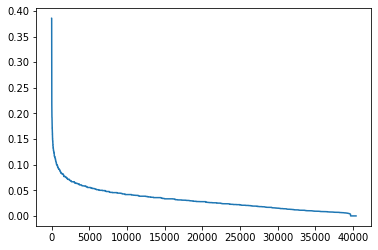

In [10]:
# for i in range(len(cov_score_mat)):
#     print(max(cov_score_mat[i]))

import numpy as np
import matplotlib.pyplot as plt

score_list = []
for tmp in cov_score_mat:
    score_list.append(max(tmp))

x = np.arange(0,len(cov_score_mat), 1);
y = np.sort(np.array(score_list))[::-1]
plt.plot(x, y)

plt.show()

In [9]:
# print(np.count_nonzero(sum(cov_matrix.toarray())))
# un_m = load_dataset("unselected_m.jsonl")

# _, _ = comparison(s1, wsc, "default")
# _, _ = comparison(s2, wsc, "default")
# _, _ = comparison(s3, wsc, "default")

In [9]:
def select_data_pieces_ids(cov_matrix, select_num, score_bar):
    # use the coverage matrix to extract a distilled set of winowhy
    score_mat = cov_matrix.toarray()
    selected_ids = []
    selected_mat = []
    
    count_list = []
    
    for tmp in score_mat:
        count_list.append(sum(tmp))
    
    # print(count_list)
    sorted_counts = np.array(count_list).argsort()[::-1]
    
    num_ids = []
    bar_ids = []
    
    # selection by number
    for i in tqdm(range(select_num)):
        selected_ids.append(int(sorted_counts[i]))
        # selected_mat.append(cov_matrix.toarray()[sorted_counts[i]])

#     score = sum(sum(selected_mat))/len(cov_matrix.toarray()[0])
#     occ_score = np.count_nonzero(sum(np.array(selected_mat)))/len(cov_matrix.toarray()[0])
    
#     if score_bar != -1:
#         tmp = select_num
#         while occ_score <= score_bar:
#             selected_ids.append(int(sorted_counts[tmp]))
#             selected_mat.append(cov_matrix.toarray()[sorted_counts[tmp]])
#             tmp += 1
            
#             score = sum(sum(selected_mat))/len(cov_matrix.toarray()[0])
#             occ_score = np.count_nonzero(sum(np.array(selected_mat)))/len(cov_matrix.toarray()[0])
    
#     print("We select " + str(len(selected_ids))+ " items.")
#     print("The coverage score is " + str(score))
#     print("The occurence score is " + str(occ_score))
    
    return selected_ids


def split_into_folds(cov_matrix, fold_num):
    folds = []
    count_list = []
    score_mat = cov_matrix.toarray()
    for tmp in score_mat:
        count_list.append(sum(tmp))
    
    sorted_counts = np.array(count_list).argsort()[::-1]
    
    folds = np.array_split(sorted_counts, fold_num)
    
    print("After spliting into " + str(fold_num) +" folds, we have " +str(len(folds[0]))+ " for each.")
    
    return folds

def split_into_folds_sent(cov_score_mat, fold_num):
    folds = []
    
    score_list = []
    for tmp in cov_score_mat:
        score_list.append(max(tmp))
        
    folds = np.array_split(np.array(score_list).argsort()[::-1],fold_num)
    foldwise_score = np.array_split(np.sort(np.array(score_list))[::-1],fold_num)
    
    print("folds scores: ", np.mean(foldwise_score[0]), np.mean(foldwise_score[1]), np.mean(foldwise_score[2]))
    
    return folds

In [10]:
# selected_ids = select_data_pieces_ids(cov_matrix,10234,-1)

In [11]:
# with open("sudo_m_ids.json","w") as f:
#     json.dump(selected_ids,f)

In [12]:
# selected_ids = select_data_pieces_ids(cov_matrix,10234,5)
# with open("sudo_l_ids.json","w") as f:
#     json.dump(selected_ids,f)

In [13]:
def generate_sudo_set(cover_set, selected_ids, output_filename):
    # generate the seleted/unselected set
    with open(output_filename,"w") as f1:
        with open("un"+output_filename,"w") as f2:
            for i,piece in enumerate(cover_set):
                if i in selected_ids:
                    f1.write(json.dumps(piece))
                    f1.write("\n")
                else:
                    f2.write(json.dumps(piece))
                    f2.write("\n")
            

In [14]:
# generate_sudo_set(xl, selected_ids, "selected_l.jsonl")

In [15]:
folds = split_into_folds_sent(cov_score_mat, 3)

folds scores:  0.1300557006200449 0.08824576200596457 0.05076479611302629


In [16]:
for i,fold in enumerate(folds):
    generate_sudo_set(xl, fold, "split_jaccard_"+str(i)+".jsonl")